# Implementing "Gibbs Sampling for the Uninitiated"

The paper in the title is absolutly amazing and I wish all research papers were actually similar to it in approach (at least to some degree). As of the time of writting I am finding myself in need to get into Bayesian Statistics in the context of my PhD. Since my knowledge of this area is practically null, I decided to to take an initial approach where I could implement a simple model (a.k.a. the most efficient way to tell if you understood something). Since I am in the NLP research area I naturally stumbled uppon the "Gibbs Sampling for the Uninitiated" paper. Dispite of 95% of the work beeing done after understanding the paper, there is still a 5% part when you try to implement it that is really annoying. The problem is that other implementations of the paper are not explicit in telling you all the details you might need. They either mention things already described in the paper or just ommit it. Therefore, I decided to compile some notes about how to implement the paper to fully bridge this gap, which hopefully will be useful to others. Additionally, I did this using both a real dataset and a synthetic one in the exeriments.

Before continuing, please be sure that you have a good understading of the paper (not a basic one, a good one) as I do not have the goal of even trying to explain the concepts better than the authors (if I had this goal I would fail miserably). The point of view for these notes is something like: "I just read the paper X times until I understand it and now I am ready to code!". I must also say, that a good understanding is enough (still need to work on Section 2.6).

Since the notebook has the goal of descrebing the development process all the code will be described. The class <i>Corpus</i> has the goal of processing corpus with positive or negative (0 or 1) sentiment labels. I used the corpus described in https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews, so the class parses any corpora in this format. The only hard task in this step is getting a document word matrix. But this can be easily obtained using the <i>CountVectorizer</i> class from scipy. A bonus of this class is that it already uses sparse matrixes out of the box. Using regular matrixes constrains the number of features (words) and documents we can use. For example, using 25000 documents and a vocabulary of 10000 words is not possible with a regular matrix (at least on regular computer). Another thing to mention are the <i>max_features</i> and <i>maxDocs</i> arguments. I found very usefull to run the code on small test cases (few documents and small vocabulary) just to see if the codes runs. It should also be noticed that the corpus can also have <i>n_training</i> instances. Fedding the model training instances is useful to have proof that the implementation is correct in a short period of time (although I only realized it later during the implementation...). If a reasonable amount of training data is given it is expected that the accuracy in the test set is high even with few iterations of the Gibbs Sampler. Finally, the <i>sent_labels</i> attribute is usefull both to see the convergence of the Gibbs sampler (at some iteration is should start to get closer to the true labels) and assess the how good the model is in the end.

In [ ]:
class Corpus(object):

    def __init__(self, sentiment_corpus_file, max_features, maxDocs=None, n_training = 0):
        self.vocab = None
        self.sent_labels = []
        self.W_D_matrix = None
        i = 0
        all_txt = []
        with open(sentiment_corpus_file, encoding="utf8") as f:
            lines = f.readlines()[1:]
            if maxDocs != None:
                lines = lines[:maxDocs]
                 
            for lin in lines:
                label, txt = self.process_lin(lin)
                all_txt.append(txt)
                self.sent_labels.append(int(label))
                i += 1
        vectorizer = CountVectorizer(analyzer = "word", strip_accents = "unicode", \
                                     stop_words = stopwords.words("english"), max_features = max_features)
        self.W_D_matrix = vectorizer.fit_transform(all_txt)
        self.N = self.W_D_matrix.shape[0]
        
        if self.N < n_training:
            raise ValueError('Bad configuration file: n_training > size of corpus')
        
        self.W_D_matrix_training = self.W_D_matrix[:n_training]
        self.W_D_matrix = self.W_D_matrix[n_training:]
        self.vocab = vectorizer.vocabulary_
        self.V = len(self.vocab)
        self.sent_labels = np.array(self.sent_labels)
        self.sent_labels_training = self.sent_labels[:n_training]
        self.sent_labels = self.sent_labels[n_training:]

The Corpus_synthetic class uses the Bayesian model described in the paper to generate a syntethic corpus. The class only needs to know the parameters of the model (<i>pi</i>, <i>theta0</i>, <i>theta1</i> arguments), how many documents we want and how long they are (<i>nDocs</i> and <i>n_word_draws</i> arguments). The it just flips a coin with weigh <i>pi</i>, <i>nDocs</i> times to generate the labels. Then <i>n_word_draws</i> from a multinomial distribution, either from <i>theta0</i> or<i>theta1</i> (depends on the result of the coin flip), are made.

Partially I wish I would have done this first and only afterwards tried a real dataset. First, generating a synthetic corps was actually very easy and little code was necessary. Second, it is the easiest way to check if the model you implemented is correct. Because if the model does not learn the parameters from a process that matches its specification then Baysian statistics would be useless. Third, we can check this very fast. This last reason is the main one that led me to actually use a synthetic corpus (only added the training part afterwards). I was testing my model with a small subset of the corpus and not getting good results. I could not tell if I had implementation issues or if the data was just not enough to get anything good out of it. Testing on the full real corpus requires weeks of computation, which is annoying. By using a synthetic corpus I could see very quickly if the mistake was mine or not (I found a huge mistake during this process). After getting the the model to work on synthetic corpus I was confident that I could run it and it would do the right thing on a real dataset.

In [ ]:
class Corpus_synthetic(object):
    def __init__(self, pi, theta0, theta1, nDocs, n_word_draws, n_training = 0):
        #fliping coins to determine the labels
        self.sent_labels = sample_bernouli(pi, nDocs)
        self.V = len(theta0)
        docs = []
        for label in self.sent_labels:
            if label == 0:
                word_vec = sample_multinomial(n_word_draws, theta0)
            else:
                word_vec = sample_multinomial(n_word_draws, theta1)
            docs.append(word_vec)
            
        self.W_D_matrix = sparse.csr_matrix(docs)
        self.N = self.W_D_matrix.shape[0]
        
        if self.N < n_training:
            raise ValueError('Bad configuration file: n_training > size of corpus')
        
        self.W_D_matrix_training = self.W_D_matrix[:n_training]
        self.W_D_matrix = self.W_D_matrix[n_training:]
        self.sent_labels_training = self.sent_labels[:n_training]
        self.sent_labels = self.sent_labels[n_training:]

The <i>ModelState</i> class is the core of the code. It is responsible for keeping track of the state of model, that is the values of the hidden variables (<i>L</i>, <i>theta0</i>, and <i>theta1</i>), and also for performing the actual Gibbs Sampling. The code snipet bellow is the initialization step of the model (Section 2.3 of the paper). It is pretty much a straighforward thing to do. We only need to be aware that the Gibbs Sampler starts in a random state, which means random assignments of the hidden variables are made. This initialization is only based on the prior values. The <i>estimated_</i> kind of variables store the values we collect in each new state we visit with the Gibbs Sampler. Therefore, in the end we only need to divide these values for the number of iterations of the Gibbs Sampler, obtaining his way an average value as the final estimation. Finally, it also necessary to take into account that we need to initialize the label counts (<i>C0</i> and <i>C1<i>) and the words counts (<i>word_counts_L0</i> and <i>word_counts_L1</i>) according to the training data.

In [ ]:
class ModelState(object):
    def __init__(self, gamma_pi0, gamma_pi1, gamma_theta, corpus, results_file):
    
        self.results_file = results_file
        if os.path.isfile(results_file):
            os.remove(results_file)   
        
        n_training = corpus.sent_labels_training.shape[0]
        n_to_estimate =  corpus.W_D_matrix.shape[0]
        
        self.corpus = corpus
        self.N = corpus.N
        self.estimated_L = np.zeros(n_to_estimate)
        #adding label counts of training instances
        self.C1 = np.count_nonzero(corpus.sent_labels_training)
        self.C0 =  n_training - self.C1
        self.theta0 = None
        self.theta1 = None
        self.gamma_pi0 = gamma_pi0
        self.gamma_pi1 = gamma_pi1
        self.gamma_theta = gamma_theta
        
        pi = sample_beta(self.gamma_pi0, self.gamma_pi1)
        self.L = sample_bernouli(pi, n_to_estimate)
        self.theta0 = sample_dirichlet(self.gamma_theta)
        self.theta1 = sample_dirichlet(self.gamma_theta)
        self.estimated_theta0 = np.zeros(self.theta0.shape[0])
        self.estimated_theta1 = np.zeros(self.theta1.shape[0])
        zero_count_L = np.count_nonzero(self.L)
        self.C1 += zero_count_L
        self.C0 += n_to_estimate - zero_count_L
        
        docs_L0, docs_L1 = self.group_by_L(self.L)
        self.word_counts_L0 = corpus.W_D_matrix[docs_L0].sum(0)
        self.word_counts_L1 = corpus.W_D_matrix[docs_L1].sum(0)
        
        #adding word counts of training instances
        docs_L0, docs_L1 = self.group_by_L(corpus.sent_labels_training)
        self.word_counts_L0 += corpus.W_D_matrix_training[docs_L0].sum(0)
        self.word_counts_L1 += corpus.W_D_matrix_training[docs_L1].sum(0)
        
    def group_by_L(self, labels):
        docs_L0 = []
        docs_L1 = []
        for doc_id, Lj in enumerate(labels):
            if Lj == 0:
                docs_L0.append(doc_id)
            else:
                docs_L1.append(doc_id)
        return docs_L0, docs_L1

The code below corresponds to the implementation of sampling method of the hidden variable <i>L</i> (Section 2.5.1 of the paper). This is actually only part in which I had some serious trouble (I told after reading the paper 95% of the work was done right?). Still this kept me scratching my head for some days and I experienced some serious frustration. The actual problem is that if Equation 49 is literarlly implemented we easily reach really low number (uderflow) and suddenly we only see zeros. This kind of situation probably rings a bell for the "log trick". The paper actaully has no mention to it and I had some trouble figuring it out. My problem was that I started to apply it <i>value0</i> and transforming it back (applying the exponential) to soon. It took me some time to figure this out because I thought the problem was in my calculations of <i>log(value0)</i> or somewhere else in the code. Eventually I found that what it needs to be done is <i>log(value0 / (value0 + value1)</i>. Below is the complete mathematical derivition of the expression:
$$log(\frac{value_0}{value_0 + value_1}) = log(value_0) - log(value_0 + value_1)$$

$$log(value_0) = log(\frac{C_0 + \gamma_{\pi 0} - 1}{N + \gamma_{\pi 0} + \gamma_{\pi 1} - 1} \prod_{i = 1}^V \theta_{x, i}^{W_{ji}}) = log(\frac{C_0 + \gamma_{\pi 0} - 1}{N + \gamma_{\pi 0} + \gamma_{\pi 1} - 1}) + log(\prod_{i = 1}^V \theta_{x, i}^{W_{ji}}) = log(\frac{C_0 + \gamma_{\pi 0} - 1}{N + \gamma_{\pi 0} + \gamma_{\pi 1} - 1}) + \sum_{i = 1}^V log(\theta_{x, i}^{W_{ji}}) = log(\frac{C_0 + \gamma_{\pi 0} - 1}{N + \gamma_{\pi 0} + \gamma_{\pi 1} - 1}) + \sum_{i = 1}^V W_{ji} log(\theta_{x, i})$$

$$log(value_0 + value_1) = log(e^{log(value_0)} + e^{log(value_1)})$$

A couple of notes on the above derivations. First, I only present the derivation for $log(value_0)$ for simplicity, $log(value_1)$ is trivial. Second, the last expression is usefull because there are built-in functions to compute it (for python numpy provides logaddexp). Finally, having $W_{ji} log(\theta_{x, i})$ is also usefull because we can easily express it as the dot product of vectors, which is fast (between if you see <i>for</i> loops in the code really try to get rid of them, they are painfully slow compared with matrix operations).

One thing that I completly got wrong from (I even feel a bit reluctant to describe it here because it is kinda stupid...) was step <i>3.</i> of the sampling procedure of <i>L</i>. Since I saw two values for the distribution I associated them to the <i>Beta</i> distribution of the $\pi$ variable. Therefore, I actually sampled from a <i>Beta</i> distribution with those values to get the coin weight for the <i>Bernouli</i> distribution in step <i>4</i>. It turns out that you only need to use $\frac{value_1}{value_0 + value_1}$ as the coin weight directly (the other value is just 1 - this value).

The last detail I would like to mention is related the description of the Gibbs Sampler (Section 2.5.4), particularly set <i>5</i>. What confused me is that we do not use words counts when sampling <i>L</i>. We still need to be aware that the assignments of the label change as the iterations progress and, thus, we need to update the words counts. But this update can be done in many different ways. For instance, I may want to first check if the label changed and update the counts afterwards, if necessary. This made review the paper a couple more times to check if I was understanding everything correctly, which is not bad. What also made me question this step is that other implementations that I saw were actually using the words counts instead of the counts of the labels. But after all my reviews I stand by point and suspect that those implementations are not correct (even emailed one of the autors of one implementation but got no response).

In [ ]:
def sample_L(self):
        for j in range(len(self.L)):
            self.sample_Lj(j)
        
def sample_Lj(self, j):
    if self.L[j] == 0:
        self.C0 = self.C0 - 1.0
        self.word_counts_L0 -= self.corpus.W_D_matrix[j]
    else:
        self.C1 = self.C1 - 1.0
        self.word_counts_L1 -= self.corpus.W_D_matrix[j]

    denom = self.C0 + self.C1 + self.gamma_pi0 + self.gamma_pi1 - 1.0
    #Computing for x = 0 (Lj = 0)
    factor1_log_L0 = np.log((self.C0 + self.gamma_pi0 - 1.0) / denom)

    #Computing for x = 1 (Lj = 1)
    factor1_log_L1 = np.log((self.C1 + self.gamma_pi1 - 1.0) / denom)

    factor2_log_L0 = self.corpus.W_D_matrix[j].dot(np.log(self.theta0))
    factor2_log_L1 = self.corpus.W_D_matrix[j].dot(np.log(self.theta1))

    log_val0 = factor1_log_L0 + factor2_log_L0
    log_val1 = factor1_log_L1 + factor2_log_L1

    post_L1 = np.exp(log_val1 - np.logaddexp(log_val0, log_val1))

    coin_weight = post_L1
    Lj_new = sample_bernouli(coin_weight, 1)

    self.L[j] = Lj_new

    if Lj_new == 0:
        self.C0 += 1
        self.word_counts_L0 += self.corpus.W_D_matrix[j]
    else:
        self.C1 += 1
        self.word_counts_L1 += self.corpus.W_D_matrix[j]

The code below samples the <i>theta</i> variables. The implementation is straightforward from Section 2.5.2 of the paper. Th only relevant thing to point out is an annoying mishap when implementing this part, but it is specific to python. I found my program had a memory leak which did not allow me to do many iterations of the Gibbs Sampler. This does not make much sense because everything is memory constant during the algorithm (the number of variables we are trying to estimate is fix). Eventually I tracked the leak to this particular part of the code. The problem was the <i>word_counts.A1</i> instruction. What this instruction does is to convert a matrix to a vector, which is no reason to cause a leak. Eventually I was ableto make a small piece of code that illustrated the problem and still could not solve. Out of despair I decided to post my question on StackOverflow (http://stackoverflow.com/questions/38360674/converting-row-of-sparse-matrix-to-dense-leaks-memory, my first question there). Luckly, I had a response and it turned out to be a bug in scipy. Since they were fixing it in the next release, which was almost coming out, I waited. This waiting period actually made me a bit impatient because I wanted to know if the program was correct. So this was the time I started to implement the synthetic corpus. 

In [ ]:
def sample_Theta0(self):
    post_theta0 = self.sample_Theta(self.gamma_theta, 0)
    self.theta0 = post_theta0
        
def sample_Theta1(self):
    post_theta1 = self.sample_Theta(self.gamma_theta, 1)
    self.theta1 = post_theta1

def sample_Theta(self, gamma_theta_prior, Cx):
    if Cx == 0:
        word_counts = self.word_counts_L0
    else:
        word_counts = self.word_counts_L1

    #NOTE: on numpy sum operations we get a matrix. With .A1 we get back an array
    t = word_counts.A1 + gamma_theta_prior
    return sample_dirichlet(t)

The method below is the actual Gibbs Sampler, which after the having the sampling procedures is peanuts. Again, it is a straightforward implementation of Section 2.5.4 of the paper. The only thing that it hads is the <i>burn-in</i> and <i>lag</i> iterations. In burn-in iterations we sample the variables but we do not add them to the estimation. Lag iterations are similar, in the sense they do not count for the variables estimation, but are interleaved with "regular" iterations (the ones we actually take into account for estimation). For example, if <i>lag = 5</i> we make sample the variables 5 times without adding them to estimate and the 6th sample we actually add to the estimation. We keep repeating this process for a number of <i>n_iter</i> times. The last thing to mention is that the code compares, in each iteration, the estimated labels with the true labels using the $F_1$ score. The results are written to file so that I can terminate the program at any time and still be able to analyze some results. If everything is right I should see a general tendancy for the score to increase as more iterations are done.

In [ ]:
def gibbs_sampler(self, n_iter, burn_in, lag):
        lag_counter = lag
        iteration = 1.0
        total_iterations = burn_in + n_iter*lag + n_iter
        t = trange(total_iterations, desc='', leave=True)
        for i in t:
            self.sample_L()
            self.sample_Theta0()
            self.sample_Theta1()
            
            if burn_in > 0:
                t.set_description("Burn-in iter %i C0 %d C1 %d" % (burn_in, self.C0, self.C1))
                burn_in -= 1
            else:
                if lag_counter > 0:
                    t.set_description("Lag iter %i\tC0 %d C1 %d" % (iteration, self.C0, self.C1))
                    lag_counter -= 1
                else:
                    t.set_description("Estimate iter %i\tC0 %d C1 %d" % (iteration, self.C0, self.C1))
                    lag_counter = lag
                    self.estimated_L += self.L
                    self.estimated_theta0 += self.theta0
                    self.estimated_theta1 += self.theta1
                    
                    with open(self.results_file, "a") as f:
                        current_estimated_L = np.rint(self.estimated_L / iteration)
                        f.write(str(f1_score(self.corpus.sent_labels, current_estimated_L))+"\n")
                        
                    iteration += 1.0
                
        self.estimated_L /= iteration
        self.estimated_L = np.rint(self.estimated_L)
        self.estimated_theta0 /= iteration
        self.estimated_theta1 /= iteration
        target_names = ['L0', 'L1']
        print(classification_report(self.corpus.sent_labels, self.estimated_L, target_names=target_names))

The final snipet of code left to describe is just a runner kind of function that ties all the privious code together. All the parameters described previously (priors, number of documents, maximum features, etc.) are specified in a configuration file. After running the Gibbs sampler plots with results (for each iteration) as well as the <i>n</i> most probable words from <i>theta0</i> and <i>theta1</i>.

In [ ]:
def plot_results(results_file):
    with open(results_file) as r_file:
        lins = r_file.readlines()[:-1]
        x = range(len(lins))
        y = []
        for lin in lins:
            y.append(float(lin))
            
        plt.plot(x, y)
        plt.ylabel('F1 score')
        plt.xlabel('Iteration')
        plt.show()
        
def plotPosterior(posteriors, labelDic, n, colors):
    f, axarr = plt.subplots(len(posteriors), squeeze=False)
    xAxis = [x/10. for x in range(0, 11)]
    for posterior, ax_i, color in zip(posteriors, range(len(posteriors)), colors):
        labelsVals = {}
        for i, val in enumerate(posterior):
            labelsVals[labelDic[i]] = val
        sorted_dic = sorted(labelsVals.items(), key=operator.itemgetter(1))
        yLabels = [label for label, val in sorted_dic[:n]]
        y_pos = np.arange(len(yLabels))/5.
        axarr[ax_i, 0].barh(y_pos, [labelsVals[y] for y in yLabels], align='center', color=color, height=0.2)
        axarr[ax_i, 0].set_yticks(y_pos)
        axarr[ax_i, 0].set_yticklabels(yLabels)

    plt.xlabel('Probability')
    plt.show()
        
if __name__ == '__main__':
    if len(sys.argv) == 1:
        config_file = '../config.txt'
    else:
        config_file = sys.argv[1]
    with open(config_file) as data_file:    
        config = json.load(data_file)
    
    results_file = config["results_file"]
    gamma_pi0 = config["gamma_pi0"]
    gamma_pi1 = config["gamma_pi1"]
    gamma_theta_val = config["gamma_theta_val"]
    maxDocs = config["maxDocs"]
    run_corpus_synthetic = config["run_corpus_synthetic"]
    n_training = config["n_training"]
    
    if maxDocs == "None":
        maxDocs = None
        
    if run_corpus_synthetic == "True":
        pi = config["synthetic_corpus"]["pi"]
        
        n_features = config["synthetic_corpus"]["n_features"]
        gamma_theta = config["synthetic_corpus"]["gamma_theta"]
        theta0 =  sample_dirichlet([gamma_theta]*n_features)
        theta1 =  sample_dirichlet([gamma_theta]*n_features)
        
        nDocs = config["synthetic_corpus"]["nDocs"]
        n_word_draws = config["synthetic_corpus"]["n_word_draws"]
        corpus = Corpus_synthetic(pi, theta0, theta1, nDocs, n_word_draws, n_training)
    else:
        corpusPath = config["sentiment_corpus"]["corpus"]
        maxFeatures = config["sentiment_corpus"]["max_features"]
        corpus = Corpus(corpusPath, maxFeatures, maxDocs, n_training)
        
    gamma_theta = np.full(corpus.V, gamma_theta_val)
    model_state = ModelState(gamma_pi0, gamma_pi1, gamma_theta, corpus, results_file)
    
    n_iter = config["n_iter"]
    burn_in = config["burn_in"]
    lag = config["lag"]
    model_state.gibbs_sampler(n_iter, burn_in, lag)
    plot_results(results_file)
    
    if run_corpus_synthetic == "False":
        inv_vocab =  {v: k for k, v in corpus.vocab.items()}
        plotPosterior([model_state.estimated_theta0, model_state.estimated_theta1], inv_vocab, 10, ['g', 'r'])

Finally it is time to run some code and see some plots. First we create a configuration file and set the flag to test on a synthetic corpus. Feel free to tweak the paramters. The porogress bar shows the current number of positive (C0) and negative (C1) labels. This is usefull to have an idea where in the state space the chain actually is. For example, if we know that there 500 labels for each class and we see C0 100 C1 900 we know for sure that we are far from the correct state (C0 500 C1 500). But not that even if we see C0 500 C1 500 it does not mean they are actually correct. The plot shows that the model gets better with each iteration, which indicates that the implementation is correct.

Estimate iter 100	C0 103 C1 197: 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]

             precision    recall  f1-score   support

         L0       0.97      0.90      0.94        72
         L1       0.95      0.98      0.97       128

avg / total       0.96      0.95      0.95       200



<IPython.core.display.Javascript object>


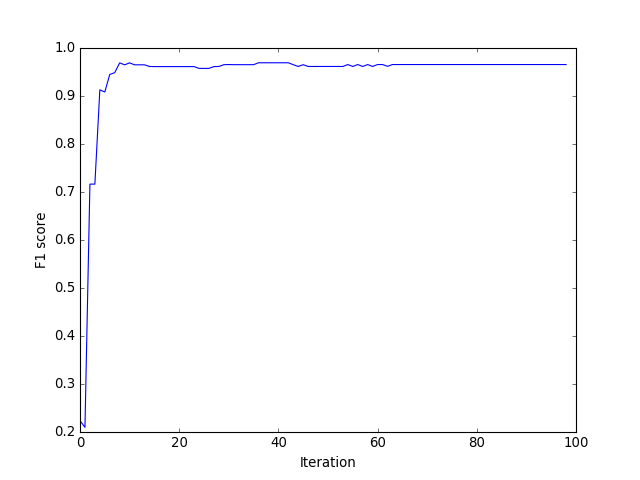

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path.append('/usr/local/lib/python3.4/site-packages')
import json

config = {
            "run_corpus_synthetic": "True",
            "results_file": "results.txt",
            "n_training": 100,
            "gamma_pi0": 40.0,
            "gamma_pi1": 40.0,
            "gamma_theta_val": 1.0,
            "n_iter": 100,
            "burn_in": 0,
            "lag": 0,
            "maxDocs": "None",

            "sentiment_corpus": {
                "max_features": 1000,
                "corpus": "labeledTrainData.tsv"
            },

            "synthetic_corpus": {
                "pi": 0.6,
                "gamma_theta": 20,
                "n_features": 100,
                "nDocs": 300,
                "n_word_draws": 100
            }
        }
with open("config_notebook.txt", "w+") as f:
    json.dump(config, f)
    
%run src/runner.py config_notebook.txt

Ok, now for a more exciting experiment, testing the model on an actual real data set. Since this is a demo of the code, I want it to make runnable in a resonable amount of time and still show that the implementation is correct. In this context, the set up will give the model 20000 training instances and test on 5000 after running for only 10 iterations (still takes some minutes). Keep in mind that having training instances is not "expensive" for the Gibbs Sampler. They just need to be added to labels and word counts vector once in the initialization. What makes a significant difference is the number of instance you want to see classified (the size of the L variable). If we have 10000 unlabled instances each iteration of the Gibbs Sampler requires the sampling of 10000 L variables. The other thing to keep in mind is the trade off between the number of training instances and the number of iterations to obtain good results. That is, if few training are provided more iterations are necessary. But this does not mean that the model is not able to learn in an unsupervised fashion (0 training intances), just means that in this situation a lot of iterations are required.

The first plot shows again the F1 score in each iteration. We can see that the score does not always increase, but in general has a tendency to do so. The final score (0.82) is pretty resonable given the low number of iterations, showing more evidence that the implementation is correct. The second plot shows the most probable words in the <i>theta1</i> and <i>theta0</i> language models. The most probable words are what we would expect of words that indicate positive/negative sentiments (funny to see that maybe there have not been many good zombie movies lately). So again, it seems we are on track. Finally, I incentativate to tweak the parameters (especially <i>n_training</i> and <i>n_iter</i>) to see the difference in the evaluation metrics and what kinds of words are most probable.

Estimate iter 10	C0 12533 C1 12467: 100%|██████████| 35/35 [01:45<00:00,  3.01s/it]

             precision    recall  f1-score   support

         L0       0.81      0.83      0.82      2472
         L1       0.83      0.81      0.82      2528

avg / total       0.82      0.82      0.82      5000



<IPython.core.display.Javascript object>


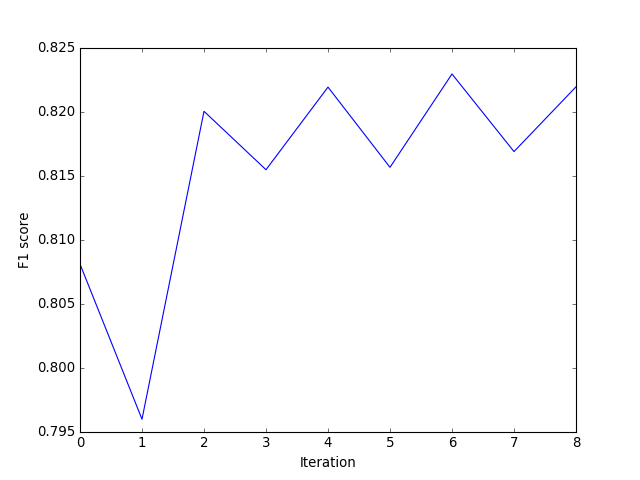

<IPython.core.display.Javascript object>


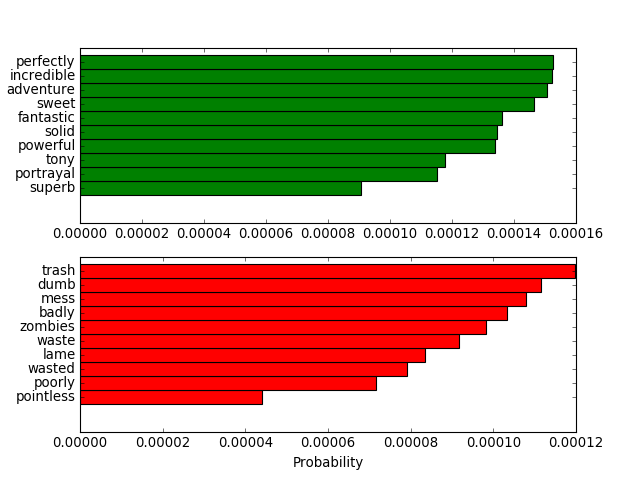

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import sys
sys.path.append('/usr/local/lib/python3.4/site-packages')
import json

config["run_corpus_synthetic"] = "False"
config["n_training"] = 20000
config["burn_in"] = 5
config["lag"] = 2
config["n_iter"] = 10

with open("config_notebook.txt", "w+") as f:
    json.dump(config, f)
    
%run src/runner.py config_notebook.txt

Thank you for reading this notebook and I hope I have done a good job in bridging the gap between understanding the "Gibbs Sampling for the Uninitiated" paper and actually implement it. Just a final disclaimer, I am still trying to classify the full sentiment dataset in an unsupervised manner but have not yet managed to get good results. Basically I need to leave the algorithm running for week so many iterations can be performed. But I feel Bayesian about the upcoming results. If the tests so far indicate the model is correct I believe the future tests have a good chance to be passed.

If you are interested in using the code of this notebook you can more easily download here:
https://github.com/pjdrm/BayesianSentimentAnalysis